In [64]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter, MultipleLocator
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import os
from cmcrameri import cm
from scipy.interpolate import PchipInterpolator
from copy import deepcopy

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
import utils.load_grid as lg
from proteus.config import read_config
from proteus.utils.constants import M_earth, M_jupiter, R_earth, R_jupiter

In [4]:
fwl_dir = os.environ.get("FWL_DATA")

In [59]:
def gauss1d(v,param):
    if v > param["mu"]:
        sig2 = param["sigp"]**2
    else:
        sig2 = param["sigm"]**2
    return np.exp(-0.5 * (v-param["mu"])**2/sig2)# / np.sqrt(2*np.pi*sig2)

def gauss2d(x,y, x_param, y_param):
    return gauss1d(x, x_param) * gauss1d(y, y_param)

In [5]:
def _get_exo_data():
    popfile = os.path.join(fwl_dir, "planet_reference", "Exoplanets", "DACE_PlanetS.csv")
    return pd.read_csv(popfile,comment="#")

def _get_mr_data():
    z19 = os.path.join(fwl_dir, "mass_radius", "Mass-radius", "Zeng2019")

    # Set paths
    curves = {
        r"1% H$_2$ (700 K)":    os.path.join(z19, "Earthlike1h700K1mbar.txt"),
        r"1% H$_2$ (500 K)":    os.path.join(z19, "Earthlike1h500K1mbar.txt"),
        r"100% H$_2$O (700 K)": os.path.join(z19, "massradius_100percentH2O_700K_1mbar.txt"),
        r"50% H$_2$O (700 K)": os.path.join(z19, "massradius_50percentH2O_700K_1mbar.txt"),
        r"MgSiO$_3$":           os.path.join(z19, "massradiusmgsio3.txt"),
        "Earth-like":           os.path.join(z19, "massradiusEarthlikeRocky.txt"),
    }

    # Replace paths with the data
    for k in curves.keys():
        data = np.loadtxt(curves[k]).T
        mask = np.argsort(data[0])
        curves[k] = [data[0][mask],data[1][mask]]

    return curves

# Get exoplanet values from database
exo = _get_exo_data()
print(list(exo.keys()))

exo_mas_val = exo["Planet Mass [Mjup]"]             * M_jupiter / M_earth
exo_mas_upp = exo["Planet Mass - Upper Unc [Mjup]"] * M_jupiter / M_earth
exo_mas_low = exo["Planet Mass - Lower Unc [Mjup]"] * M_jupiter / M_earth

exo_rad_val = exo["Planet Radius [Rjup]"]             * R_jupiter / R_earth
exo_rad_upp = exo["Planet Radius - Upper Unc [Rjup]"] * R_jupiter / R_earth
exo_rad_low = exo["Planet Radius - Lower Unc [Rjup]"] * R_jupiter / R_earth

exo_age_val = np.array(exo["Stellar Age [Gyr]"]   )  * 1e9    # yr
exo_rho_val = np.array(exo["Planet Density [g/cm**3] - Computation"]) # g cm-3

# Get Mass-Radius curves from files
mrdata = _get_mr_data()

['Unnamed: 0', 'Planet Name', 'Planet Letter', 'Host Name', 'TIC ID', 'Gaia DR3 ID', 'Discovery Year', 'Discovery Method', 'Discovery Facility', 'Discovery Locale', 'Number of stars', 'Number of planets', 'Reference', 'ADS link', 'Last Updated', 'Planet Mass [Mjup]', 'Planet Mass - Upper Unc [Mjup]', 'Planet Mass - Lower Unc [Mjup]', 'Relative Mass Error', 'Planet Msin(i) [Mjup]', 'Planet Msin(i) - Upper Unc [Mjup]', 'Planet Msin(i) - Lower Unc [Mjup]', 'Planet Radius [Rjup]', 'Planet Radius - Upper Unc [Rjup]', 'Planet Radius - Lower Unc [Rjup]', 'Relative Radius Error', 'Orbital Period [days]', 'Orbital Period - Upper Unc [days]', 'Orbital Period - Lower Unc [days]', 'Orbit Semi-Major axis [au]', 'Orbit Semi-Major axis - Upper Unc [au]', 'Orbit Semi-Major axis - Lower Unc [au]', 'Source of the Orbit Semi-Major axis', 'Eccentricity', 'Eccentricity - Upper Unc', 'Eccentricity - Lower Unc', 'Eccentricity Upper Limit Flag', 'Insolation Flux [Earth Flux]', 'Insolation Flux - Upper Unc [Ea

In [6]:
t0 = 1e2
m_max = 5
m_min = 0.1

In [7]:
pgrid_dir = "data/output/l98d_escape10/"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

cnums = ["%d"%int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

# transit, eclipse = lg.load_synthobs(cases)

print("Done")

Helpfiles:   4%|▎         | 2/54 [00:00<00:03, 13.57it/s]

Helpfiles: 100%|██████████| 54/54 [00:03<00:00, 16.94it/s]


Done


## Density over time

In [8]:
age_start = float(helps[0]["age_star"].iloc[0])

Cases which match density/age observations:
[18, 19, 20, 21, 22, 23, 24, 25, 26]


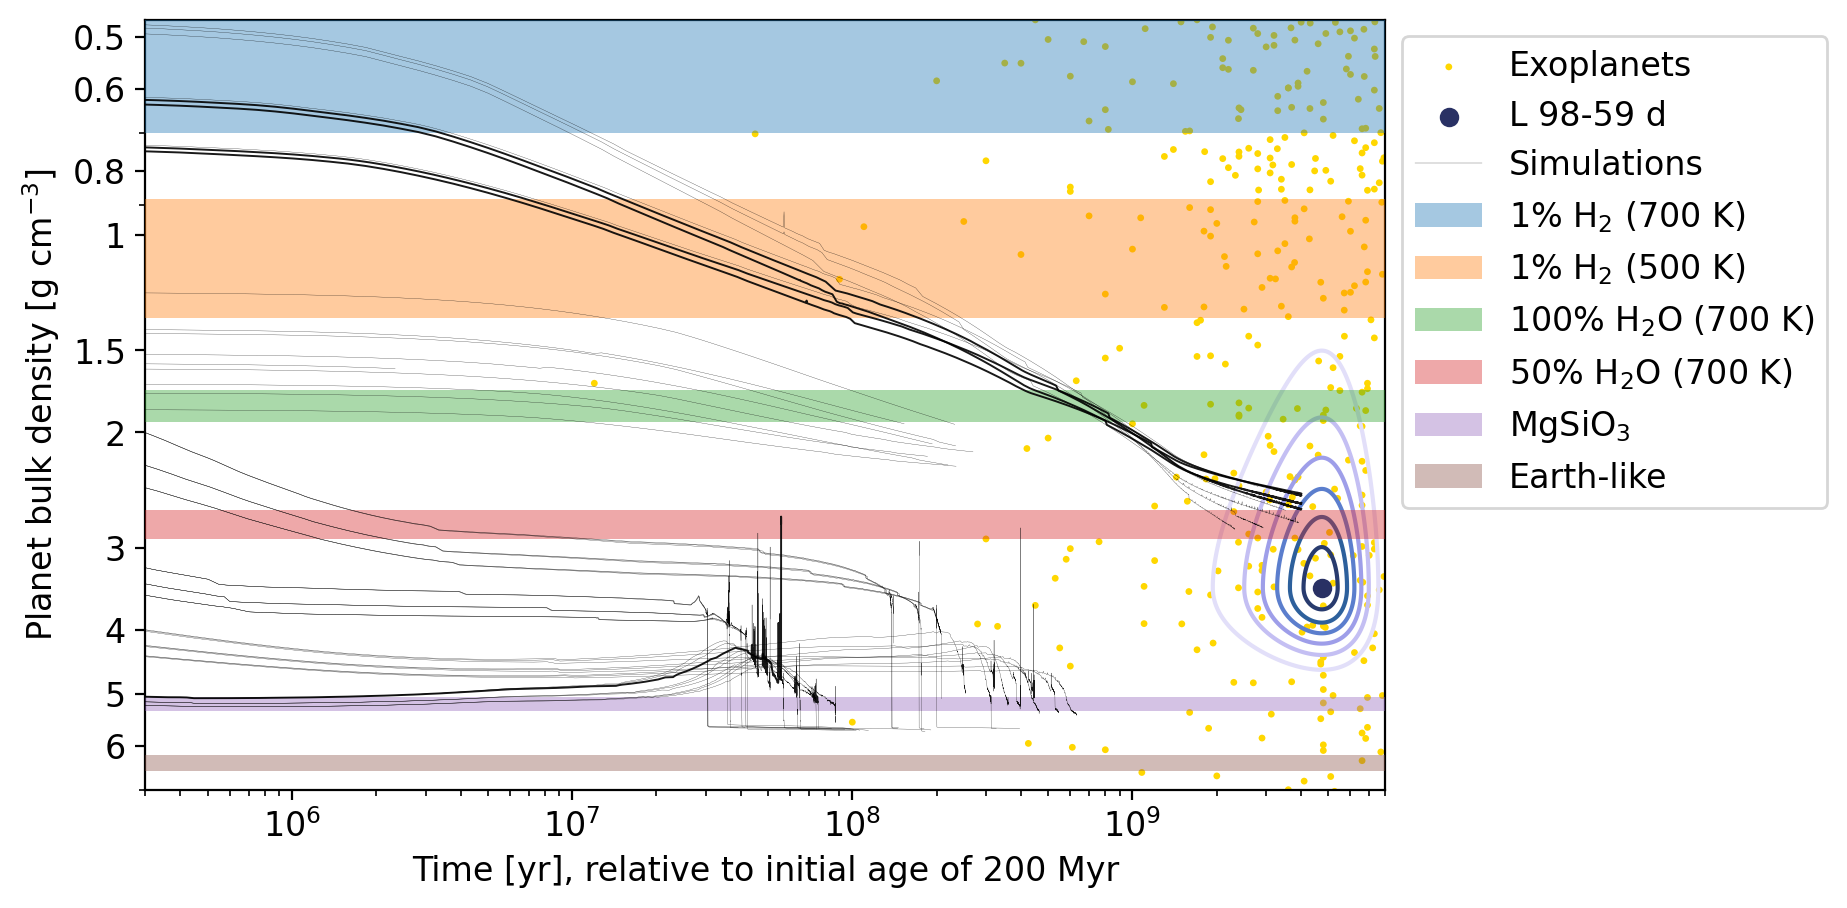

In [94]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ymin, ymax = 1.0, 7
tmin, tmax = 3e5, 8e9


# Exoplanets
ax.scatter(exo_age_val-age_start, exo_rho_val,
            color='gold', label="Exoplanets", s=6, zorder=1, edgecolors='none')

# Observations
# rho_max = 3.45+0.59  # +1 sigma, Rajpaul+24
# rho_min = 3.45-1.00  # -1 sigma, Rajpaul+24
# age_min = 800e6      # Lower limit, Demangeon+24
# age_max = 5.22e9     # +1 sigma, Engle+24
# ax.fill_between(np.array([age_min, age_max])-age_start, rho_min, rho_max,
#                     label="L 98-59 d", color='goldenrod', zorder=2, hatch='..', edgecolor='k')

age_param = {"mu":4.94e9, "sigm":1.44e9, "sigp":1.44e9}
rho_param = {"mu":3.45,   "sigm":1.0,    "sigp":0.59}
x_inp = np.linspace(1e9, 8e9, 200)
y_inp = np.linspace(1, 5, 200)
z_arr = np.zeros((len(x_inp), len(y_inp)))
for i,x in enumerate(x_inp):
    for j,y in enumerate(y_inp):
        z_arr[j,i] = gauss2d(x, y, age_param, rho_param)
vmin = np.percentile(z_arr, 2)
cmap = deepcopy(cm.devon_r)
ax.contour(x_inp-age_start,y_inp, z_arr, cmap=cmap, vmin=vmin) # make contours
ax.scatter(age_param["mu"]-age_start,rho_param["mu"],
            color=cmap(0.9), label="L 98-59 d") # legend entry

masses_all = []
matches_rho = []
for i in range(ncases):
    hf_all = helps[i]

    # get index of closest time
    hf_crop = hf_all[3:]

    col = 'k'
    ls = 'solid'
    lw = 0.7
    lbl = ""
    if i == 0:
        lbl = "Simulations"
    if not (10 < stts[i] < 19):
        lw=0.1

    # get data
    time = np.array(hf_crop["Time"])
    sim_tmp = np.array(hf_crop["T_surf"])
    sim_rad = np.array(hf_crop["R_obs"])
    sim_mas = np.array(hf_crop["M_planet"])
    sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001
    sim_rad /= R_earth
    sim_mas /= M_earth

    # store mass statistics
    masses_all.extend(sim_mas)
    ymin = min(ymin, np.amin(sim_rho))

    # does this case pass through observed region?
    rho_min = rho_param["mu"]-rho_param["sigm"]*2
    rho_max = rho_param["mu"]+rho_param["sigp"]*2
    age_min = age_param["mu"]-age_param["sigm"]*2
    age_max = age_param["mu"]+age_param["sigp"]*2
    mask = np.argwhere( (sim_rho >= rho_min) & ( sim_rho <= rho_max))
    ages = time[mask] + age_start
    if np.any( (ages >= age_min) & (ages <= age_max)):
        matches_rho.append(i)

    # plot
    ax.plot(time, sim_rho, color=col, lw=lw, alpha=0.9, zorder=7, label=lbl, ls=ls)

print("Cases which match density/age observations:")
print(matches_rho)

# M-R curves
mass_min = np.amin(masses_all)
mass_max = np.amax(masses_all)
for k in mrdata.keys():
    m_curve = mrdata[k][0] * M_earth
    r_curve = mrdata[k][1] * R_earth
    rho_curve = 3*m_curve/(4*np.pi*r_curve**3)  * 0.001

    rho_interp = PchipInterpolator(m_curve, rho_curve)
    rho_min = rho_interp(mass_min * M_earth)
    rho_max = rho_interp(mass_max * M_earth)
    ax.fill_between([tmin, tmax], rho_min, rho_max, zorder=5, label=k, alpha=0.4)


ax.set_xlim(left=tmin, right=tmax)
ax.set_xlabel("Time [yr], relative to initial age of %g Myr"%(age_start/1e6))
ax.set_xscale("log")

ax.set_ylabel(r"Planet bulk density [g cm$^{-3}$]")
ax.set_yscale("log")
ax.set_ylim(bottom=ymax, top=ymin)
ax.set_yticks([0.5,  0.6, 0.8, 1, 1.5, 2, 3, 4, 5, 6])
ax.yaxis.set_major_formatter(FormatStrFormatter("%g"))

ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## Animation

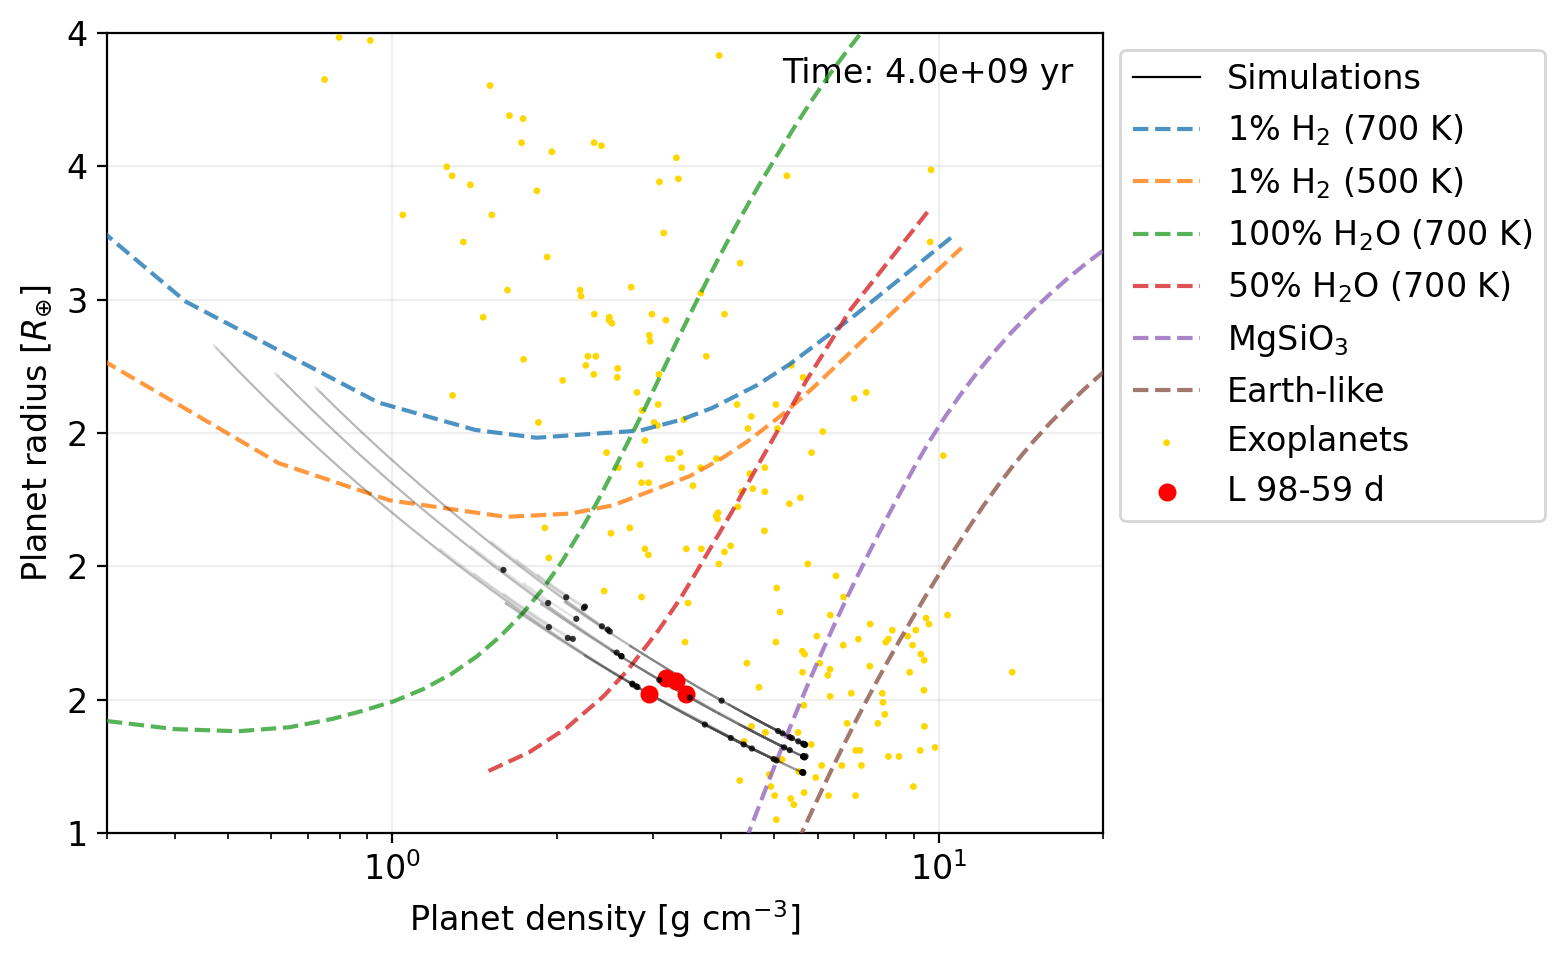

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

xmin, xmax = 0.3, 20
ymin, ymax = 1.0, 4
tmin, tmax = 1e4, 1e5

ax.set_ylabel(r"Planet radius [$R_{\oplus}$]")
# ax.set_yscale("log")
ax.set_ylim(ymin, ymax)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.0f"))

ax.set_xlabel(r"Planet density [g cm$^{-3}$]")
ax.set_xscale("log")
ax.set_xlim(xmin, xmax)

lines = []

# Create lines for simulations
for i in range(ncases):
    x,y = [], []
    if i == 0:
        lbl = "Simulations"
    else:
        lbl = ""
    l = ax.plot(x, y, color='k', lw=0.8, zorder=13, label=lbl)[0]
    lines.append(l)

# Create endpoints
for i in range(ncases):
    x,y = [],[]
    l = ax.scatter(x, y, color='k', s=5, zorder=13, edgecolors='none')
    lines.append(l)

    # get time
    tmax = max(tmax, np.amax(helps[i]["Time"]))

# Time
l = ax.text(0.97, 0.97, "Time: [unset]", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
lines.append(l)
itext = len(lines)-1

# M-R curves
for k in mrdata.keys():
    m = mrdata[k][0] * M_earth
    r = mrdata[k][1] * R_earth
    rho = 3*m/(4*np.pi*r**3)  * 0.001
    l = ax.plot(rho,r/R_earth, label=k, linestyle='dashed', alpha=0.8, zorder=10)[0]
    lines.append(l)

# Exoplanets
lbl = "Exoplanets"
ms=6
l = ax.scatter(exo_rho_val, exo_rad_val, color='gold', label=lbl, s=ms, zorder=9, edgecolors='none')
lines.append(l)

# Radius valley
# l = ax.fill_between([xmin,xmax], 1.5, 2.0, zorder=8,alpha=0.2, color='gold', ec='none', label="Radius valley")
# lines.append(l)

# Observations
lines.append(ax.scatter(2.95,1.52, s=30, zorder=12, color='red', label="L 98-59 d"))
lines.append(ax.scatter(3.45,1.52, s=30, zorder=12, color='red'))
lines.append(ax.scatter(3.17,1.58, s=30, zorder=12, color='red'))
lines.append(ax.scatter(3.30,1.57, s=30, zorder=12, color='red'))

# Decorate
ax.grid(alpha=0.2, zorder=-2)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.tight_layout()

def update(t):

    # for each case
    for i in range(ncases):
        hf_all = helps[i]

        # get index of closest time
        idx_close = np.argmin(np.abs(t - hf_all["Time"]))
        hf_crop = hf_all.iloc[range(idx_close)]
        if len(hf_crop["Time"]) < 3:
            continue

        col = 'k'

        # get data
        time = np.array(hf_crop["Time"])
        sim_tmp = np.array(hf_crop["T_surf"])
        sim_rad = np.array(hf_crop["R_obs"])
        sim_mas = np.array(hf_crop["M_planet"])
        sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001

        sim_rad /= R_earth
        sim_mas /= M_earth

        x = sim_rho
        y = sim_rad

        iline = i
        iscat = i + ncases

        lines[iline].set_data(x, y)
        lines[iscat].set_offsets([x[-1],y[-1]])

        # is this the last sample?
        if idx_close >= len(hf_all)-1:
            # yes
            lines[iscat].set_alpha(0.8)
            lines[iline].set_alpha(0.1)
            lines[iline].set_zorder(11)
        else:
            # no
            lines[iscat].set_alpha(0.0)
            lines[iline].set_alpha(0.8)

    lines[itext].set_text("Time: %.1e yr"%t)

    return lines

duration = 8.0
nframes  = 40

# make animation
time_arr = np.logspace(np.log10(tmin), np.log10(tmax), nframes)
ani = FuncAnimation(fig, update, frames=time_arr, blit=True, interval=duration/len(time_arr)*1e3)

# save and show
ani.save(filename="output/animate.gif", writer="ffmpeg")
HTML(ani.to_jshtml())